In [ ]:
!pip install torch-dreams --upgrade

## Welcome to torch-dreams

<img src = "https://raw.githubusercontent.com/Mayukhdeb/torch-dreams/master/images/tiger_cover.gif">

In case you don't already know what it's about, torch-dreams is a simple python library which can be used to generate deep-dreams on PyTorch models. It's not necessary to know PyTorch in order to use this library, because that's what `torch_dreams.simple` is made for. 

In [37]:
from torch_dreams.simple import vgg19_dreamer
import torch_dreams.utils as utils
import cv2 ## for saving images
import matplotlib.pyplot as plt
from torchvision import models
import torch_dreams.dreamer as dreamer

plt.rcParams['figure.figsize'] = 10, 10


In [ ]:
!wget https://i.pinimg.com/originals/af/7d/ef/af7def63c44526cecf13defd27530fd2.jpg

## Using `torch_dreams.simple` to generate a deep dream

<img src = "https://raw.githubusercontent.com/Mayukhdeb/torch-dreams/master/images/island_deep_dream.gif" width = "65%">

Currently, `torch_dreams.simple` contains only one model and that is the vgg19, but I plan to add more pre-trained models here pretty soon.

If you're unfamiliar with the concept of deep-dreams, here's a dummy's guide to tweaking the arguments in `simple_dreamer.dream()`

* `layer_index` : specifies the layer whose gradient is to be maximised. The values could range from `[0]` (first layer) to `[33]` (last layer). 
> Higher the `layer_index`, weirder the deep-dreams. 


* `iterations` : specifies the number of times each image gets added by the gradients.
> more `iterations` => weirder deep-dreams.

* `num_octaves`: specifies the number of octaves of the same image that the deep-learning model sees. The deep learning model first starts out by getting small images as input and then slowly gets larger and larger versions of the same image until it finally reaches the original size. 
> *Suggested: Keep this value in between 2 and 7 if you just want to get things going.*

* `octave_scale`: this is the factor by which the size of the image in each octave increases until it reaches back to it's original size. 
> *Suggested: Keep this value in between 1.2 to 1.45, and it'll do well on images of most sizes.*

* `Size`: this is an optional argument which resizes the image before the octaves are generated. If your image is too large, try resizing it to a smaller size for a faster but lower quality deep-dream.

* `lr`: analogous to the learning rate term used in deep-learning, it's the same thing basically. Too low and things never move, too high and things explode. Try to keep it in the order of 10^-1 or below. The default value is 0.09.  

In [56]:
from torch_dreams.simple import vgg19_dreamer
import cv2 ## for saving images

simple_dreamer = vgg19_dreamer()

dreamed_image = simple_dreamer.dream(
    image_path = "af7def63c44526cecf13defd27530fd2.jpg",
    layer_index= 17,
    iterations= 4,
    num_octaves = 5
    # size = (256,256)
)

100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


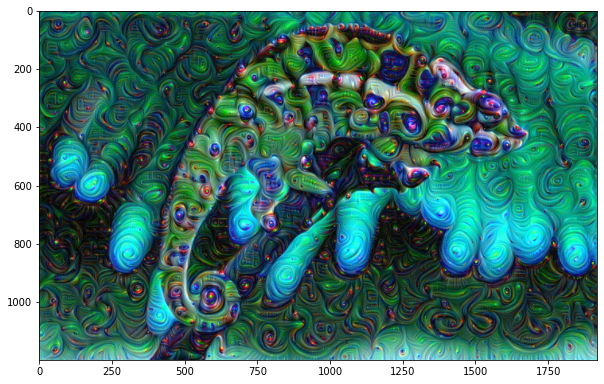

In [57]:
plt.imshow(dreamed_image)

## Deep-dreams on a video 

But first we'll download a video from youtube using [pytube](https://pypi.org/project/pytube/).

In [ ]:
!pip install pytube3 --upgrade
from pytube import YouTube

In [5]:
url = "https://www.youtube.com/watch?v=gPmKG20bElQ"

yt = YouTube(url)

yt.streams.all()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  """


[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">,
 <Stream: itag="247" mime_type="video/webm" res="720p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d4014" progressive="False" type="video">,
 <Stream: itag="244" mime_type="video/webm" res="480p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d401e" progressive="False" type="video">,
 <Stream: itag="243" mime_type="video/webm" res="360p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: i

In [6]:
video_name = yt.streams.get_by_itag('134').download()

In [8]:
from torch_dreams.simple import vgg19_dreamer

simple_dreamer = vgg19_dreamer()

## Deep-dreams on a video

The function `simple_dreamer.deep_dream_on_video()` takes in a video file as an input and returns another video file. Here's a quick guide to tweaking the arguments:

* `layer:` specifies the layer whose gradients are to be maximized and added upon the frames. `simple_dreamer.layers[0]` refers to the first layer


* `skip_value`: number of frames to skip after each iteration from the original video. `skip_value = 1` means the function would run on all frames. `skip_value = 10` means it'll skip 10 frames from the original in each iteration of the deeo-dream video generation.

In [ ]:
simple_dreamer.deep_dream_on_video(
    video_path = video_name,
    save_name = "dream.mp4",
    layer = simple_dreamer.layers[10],
    octave_scale= 1.3,
    num_octaves = 5,
    iterations=5,
    lr = 0.09,
    framerate= 30.0,
    skip_value =  1,
)

In [27]:
!cp dream.mp4 /content/drive/"My Drive"/torch_dreams/

## Moving on to the not so simple but more flexible class `torch_dreams.dreamer()`

This class could act as a wrapper on almost any kind of CNN on PyTorch. But for now we can casually test it out on the resnet50. 

The `torch_dreams.dreamer()` needs three things in order to work:

* `model`: any pytorch model with (preferably) pre-trained weights. It could be your own model as well. 

* `preprocess` refers to a set of torchvision.transforms that you'd want to apply to your images before the deep-dreams are initiated. The transforms should be wrapped in a function [as shown here](https://github.com/Mayukhdeb/torch-dreams/blob/9c18b4175cb32dacb0dc0d2bcf0abc743016a765/torch_dreams/utils.py#L31) in `preprocess_func`.

* `deprocess`: optional function which could be used to un-normalise the image before returning. 

In [ ]:
model= models.resnet50(pretrained=True)
model.eval()

In [45]:
layers = list(model.children())
layer = layers[5]

In [46]:
preprocess = utils.preprocess_func
deprocess = None

100%|██████████| 8/8 [00:18<00:00,  2.36s/it]


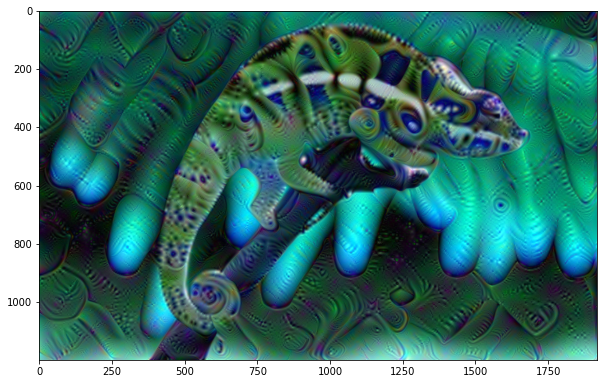

In [49]:
agent = dreamer(model, preprocess, deprocess)

image_sample = cv2.imread("af7def63c44526cecf13defd27530fd2.jpg")

dreamed = agent.deep_dream(
                        image_np =image_sample, 
                        layer = layer, 
                        octave_scale = 1.3, 
                        num_octaves = 7, 
                        iterations = 40, 
                        lr = 0.18,
                        )
plt.imshow(dreamed)
plt.show()  